In [25]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm  # <--- progress bar

# ---- Config ----
classes = ['Drones', 'Cars', 'People']  # List your classes here
input_base = r'G:\Machine Learning\Telco\RADAR_Signal_Classification\dataset'
output_base = r'G:\Machine Learning\Telco\RADAR_Signal_Classification\images'

for cls in classes:
    input_root = os.path.join(input_base, cls)
    output_root = os.path.join(output_base, cls)
    os.makedirs(output_root, exist_ok=True)
    print(f'\nProcessing class: {cls}')
    
    # Collect all .csv file paths in advance for a global progress bar
    csv_files = []
    subdirs = []
    for subdir, dirs, files in os.walk(input_root):
        rel_subdir = os.path.relpath(subdir, input_root)
        out_dir = os.path.join(output_root, rel_subdir)
        os.makedirs(out_dir, exist_ok=True)
        for file in files:
            if file.endswith('.csv'):
                csv_files.append(os.path.join(subdir, file))
                subdirs.append(out_dir)
    
    for i in tqdm(range(len(csv_files)), desc=f"{cls} CSVs"):
        path = csv_files[i]
        out_dir = subdirs[i]
        file = os.path.basename(path)
        # Read matrix
        matrix = pd.read_csv(path, header=None).values

        # Normalize and convert to 0-255 uint8 for image
        minval = np.min(matrix)
        maxval = np.max(matrix)
        norm = (matrix - minval) / (maxval - minval + 1e-8)
        img = (norm * 255).astype(np.uint8)

        # Save image
        out_path = os.path.join(out_dir, file.replace('.csv', '.png'))
        plt.imsave(out_path, img, cmap='jet')  # Use 'gray' if you prefer

    print(f"Finished class: {cls}")

print("All classes done converting CSVs to images!")


Processing class: Drones


Drones CSVs: 100%|██████████| 5065/5065 [00:11<00:00, 452.71it/s]


Finished class: Drones

Processing class: Cars


Cars CSVs: 100%|██████████| 5720/5720 [00:12<00:00, 452.83it/s]


Finished class: Cars

Processing class: People


People CSVs: 100%|██████████| 6700/6700 [00:14<00:00, 447.26it/s]

Finished class: People
All classes done converting CSVs to images!


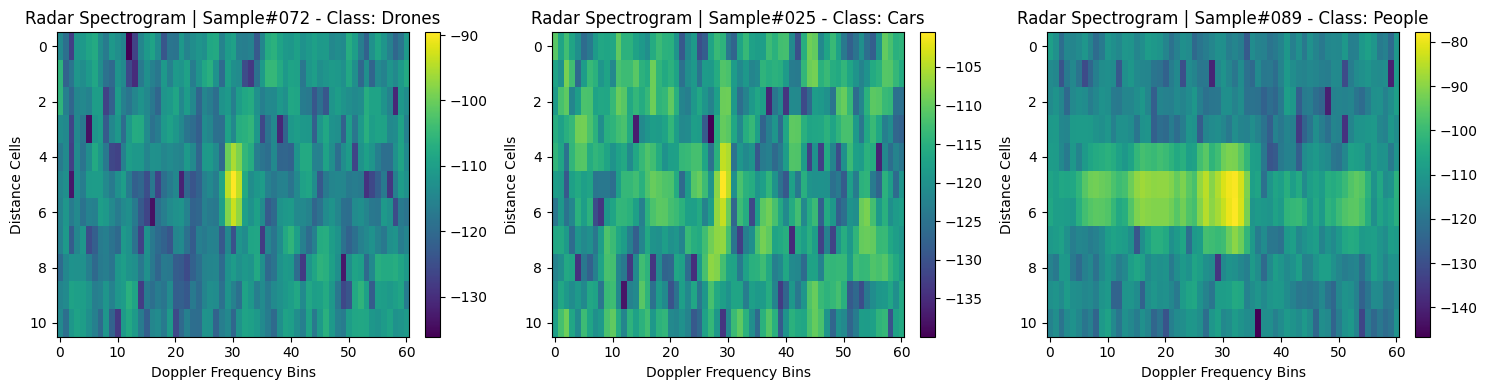

In [26]:
import os
import numpy as np
import matplotlib.pyplot as plt
import random

# ---- Config ----
base_folder = r'G:\Machine Learning\Telco\RADAR_Signal_Classification\dataset'
classes = ['Drones', 'Cars', 'People']

n_examples = 3  # Number of samples to show

plt.figure(figsize=(15, 4))

sample_idx = 1
for cls in classes:
    class_folder = os.path.join(base_folder, cls)
    # Find all CSV files in all subfolders
    filelist = []
    for subdir, _, files in os.walk(class_folder):
        filelist += [os.path.join(subdir, f) for f in files if f.endswith('.csv')]
    if len(filelist) == 0:
        continue
    # Choose a random sample from this class
    sample_path = random.choice(filelist)
    matrix = np.loadtxt(sample_path, delimiter=',')

    ax = plt.subplot(1, n_examples, sample_idx)
    im = ax.imshow(matrix, aspect='auto', cmap='viridis')
    title = f"Radar Spectrogram | Sample#{os.path.splitext(os.path.basename(sample_path))[0]} - Class: {cls}"
    ax.set_title(title)
    ax.set_xlabel("Doppler Frequency Bins")
    ax.set_ylabel("Distance Cells")
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    sample_idx += 1
    if sample_idx > n_examples:
        break

plt.tight_layout()
plt.show()

In [33]:
import os
import shutil

# Set source (original deep structure) and target (flat) directories
source = r'G:\Machine Learning\Telco\RADAR_Signal_Classification\images'
target = r'G:\Machine Learning\Telco\RADAR_Signal_Classification\flat_dataset'

os.makedirs(target, exist_ok=True)

for cls in os.listdir(source):
    class_dir = os.path.join(source, cls)
    if not os.path.isdir(class_dir):
        continue

    # Destination folder for this class
    out_dir = os.path.join(target, cls)
    os.makedirs(out_dir, exist_ok=True)

    img_count = 0
    for dirpath, _, files in os.walk(class_dir):
        for f in files:
            if f.lower().endswith('.png'):
                # Source image path
                src_path = os.path.join(dirpath, f)
                # Make unique file name: prefix with subfolder if needed
                rel = os.path.relpath(dirpath, class_dir)
                if rel != ".":
                    # e.g. 13-13_001.png
                    out_name = f"{rel}_{f}"
                else:
                    out_name = f
                dst_path = os.path.join(out_dir, out_name)
                # If file exists, add number
                count = 1
                base, ext = os.path.splitext(out_name)
                while os.path.exists(dst_path):
                    dst_path = os.path.join(out_dir, f"{base}_{count}{ext}")
                    count += 1
                shutil.copy2(src_path, dst_path)
                img_count += 1
    print(f"Class '{cls}': {img_count} images copied to {out_dir}")

print("\n✅ All classes flattened into 'flat_dataset' with no subfolders!")

Class 'Cars': 5720 images copied to G:\Machine Learning\Telco\RADAR_Signal_Classification\flat_dataset\Cars
Class 'Drones': 5065 images copied to G:\Machine Learning\Telco\RADAR_Signal_Classification\flat_dataset\Drones
Class 'People': 6700 images copied to G:\Machine Learning\Telco\RADAR_Signal_Classification\flat_dataset\People

✅ All classes flattened into 'flat_dataset' with no subfolders!


In [34]:
import os
import shutil
import random

# ---- CONFIG ----
source = r'G:\Machine Learning\Telco\RADAR_Signal_Classification\flat_dataset'
target = r'G:\Machine Learning\Telco\RADAR_Signal_Classification\dataset_split'
splits = ['train', 'val', 'test']
ratios = [0.7, 0.15, 0.15]  # must sum to 1

os.makedirs(target, exist_ok=True)
assert abs(sum(ratios) - 1.0) < 1e-6, "Ratios must sum to 1.0!"

for cls in os.listdir(source):
    class_dir = os.path.join(source, cls)
    if not os.path.isdir(class_dir):
        continue

    files = [os.path.join(class_dir, f) for f in os.listdir(class_dir) if f.lower().endswith('.png')]
    n = len(files)
    if n == 0:
        print(f"WARNING: No images found in class {cls}. Skipping.")
        continue

    print(f"Class '{cls}': {n} images found.")

    random.shuffle(files)
    idx1 = int(n * ratios[0])
    idx2 = idx1 + int(n * ratios[1])
    split_files = [files[:idx1], files[idx1:idx2], files[idx2:]]

    for split, flist in zip(splits, split_files):
        out_dir = os.path.join(target, split, cls)
        os.makedirs(out_dir, exist_ok=True)
        for f in flist:
            shutil.copy2(f, out_dir)
        print(f"  {split}: {len(flist)} images -> {out_dir}")

print("\n✅ Flat dataset split complete. All images are in train/val/test with no subfolders inside class folders!")

Class 'Cars': 5720 images found.
  train: 4003 images -> G:\Machine Learning\Telco\RADAR_Signal_Classification\dataset_split\train\Cars
  val: 858 images -> G:\Machine Learning\Telco\RADAR_Signal_Classification\dataset_split\val\Cars
  test: 859 images -> G:\Machine Learning\Telco\RADAR_Signal_Classification\dataset_split\test\Cars
Class 'Drones': 5065 images found.
  train: 3545 images -> G:\Machine Learning\Telco\RADAR_Signal_Classification\dataset_split\train\Drones
  val: 759 images -> G:\Machine Learning\Telco\RADAR_Signal_Classification\dataset_split\val\Drones
  test: 761 images -> G:\Machine Learning\Telco\RADAR_Signal_Classification\dataset_split\test\Drones
Class 'People': 6700 images found.
  train: 4690 images -> G:\Machine Learning\Telco\RADAR_Signal_Classification\dataset_split\train\People
  val: 1005 images -> G:\Machine Learning\Telco\RADAR_Signal_Classification\dataset_split\val\People
  test: 1005 images -> G:\Machine Learning\Telco\RADAR_Signal_Classification\datase

In [36]:
import os
source = r'G:\Machine Learning\Telco\RADAR_Signal_Classification\images'
target = r'G:\Machine Learning\Telco\RADAR_Signal_Classification\dataset_split'

src_count = sum([len([f for f in files if f.endswith('.png')]) 
                for _, _, files in os.walk(source)])
tgt_count = sum([len([f for f in files if f.endswith('.png')]) 
                for _, _, files in os.walk(target)])

print("Original images:", src_count)
print("Copied to split:", tgt_count)

Original images: 17485
Copied to split: 17485


Epoch 1/50 | Train Loss: 0.3757 | Train Acc: 0.865 | Val Loss: 0.6669 | Val Acc: 0.842
Epoch 2/50 | Train Loss: 0.2299 | Train Acc: 0.916 | Val Loss: 0.1818 | Val Acc: 0.921
Epoch 3/50 | Train Loss: 0.1698 | Train Acc: 0.936 | Val Loss: 0.2333 | Val Acc: 0.916
Epoch 4/50 | Train Loss: 0.1544 | Train Acc: 0.942 | Val Loss: 0.1817 | Val Acc: 0.931
Epoch 5/50 | Train Loss: 0.1384 | Train Acc: 0.952 | Val Loss: 0.1911 | Val Acc: 0.933
Epoch 6/50 | Train Loss: 0.1292 | Train Acc: 0.954 | Val Loss: 0.1915 | Val Acc: 0.931
Epoch 7/50 | Train Loss: 0.1258 | Train Acc: 0.952 | Val Loss: 0.2019 | Val Acc: 0.936
Epoch 8/50 | Train Loss: 0.1224 | Train Acc: 0.955 | Val Loss: 0.2435 | Val Acc: 0.933
Epoch 9/50 | Train Loss: 0.1240 | Train Acc: 0.955 | Val Loss: 3.4243 | Val Acc: 0.846
Epoch 10/50 | Train Loss: 0.2643 | Train Acc: 0.917 | Val Loss: 0.1745 | Val Acc: 0.936
Epoch 11/50 | Train Loss: 0.1517 | Train Acc: 0.945 | Val Loss: 0.1756 | Val Acc: 0.933
Epoch 12/50 | Train Loss: 0.1340 | Train 

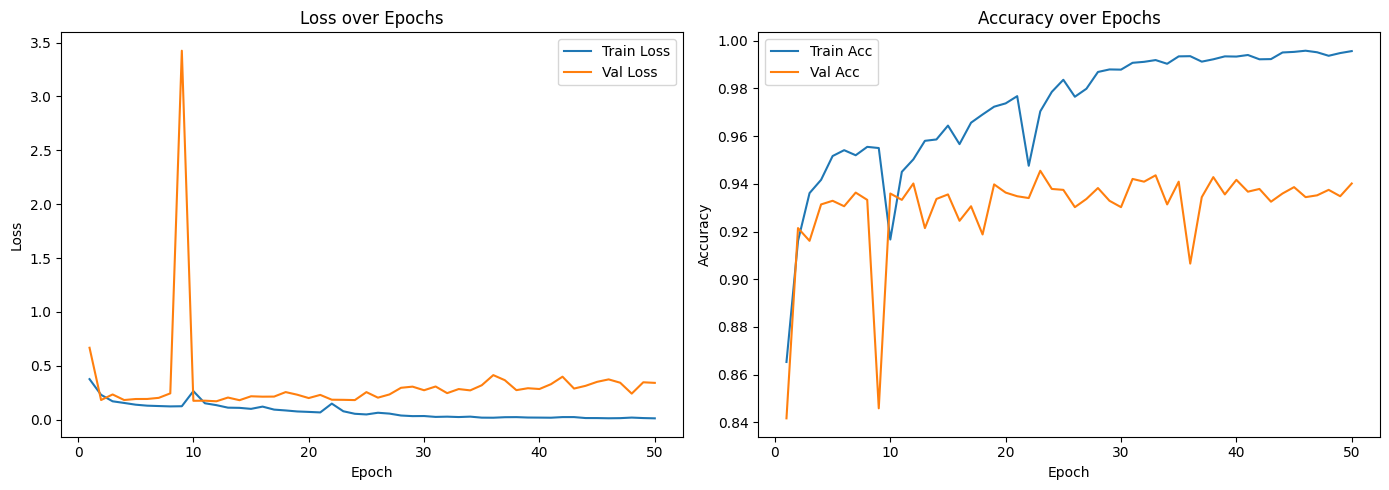

C:\Users\User\AppData\Local\Temp\ipykernel_18740\348937969.py:123: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_resnet50_radar.pth"))

Test Accuracy: 0.944
Classification Report:
               precision    recall  f1-score   support

        Cars     0.9234    0.9127    0.9180       859
      Drones     0.9012    0.9225    0.9117       761
      People     0.9960    0.9881    0.9920      1005

    accuracy                         0.9444      2625
   macro avg     0.9402    0.9411    0.9406      2625
weighted avg     0.9448    0.9444    0.9445      2625

Confusion Matrix:
 [[784  73   2]
 [ 57 702   2]
 [  8   4 993]]


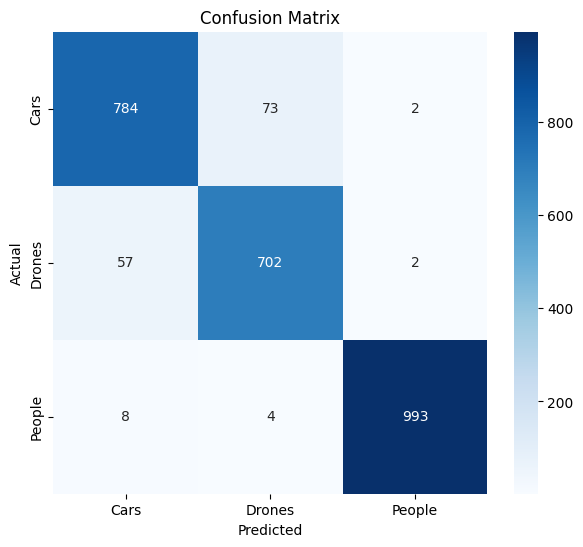

Accuracy for class Cars: 0.9127
Accuracy for class Drones: 0.9225
Accuracy for class People: 0.9881


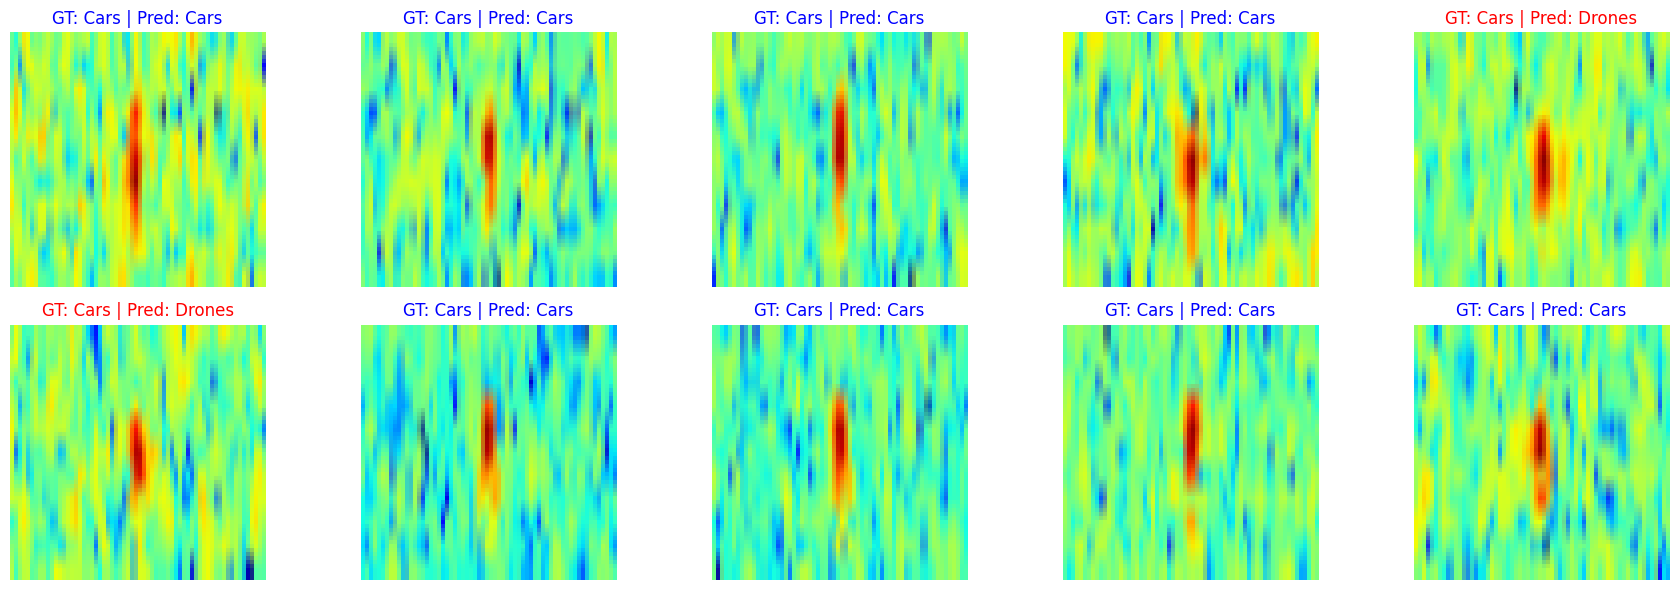

In [37]:
import os
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt

# ---- Config ----
data_dir = r'G:\Machine Learning\Telco\RADAR_Signal_Classification\dataset_split'
num_classes = 3
batch_size = 32
num_epochs = 50
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# ---- Data Augmentation & Transforms ----
transform = transforms.Compose([
    transforms.Resize((64, 64)),   # resize tiny images for ResNet input
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])  # simple normalization
])

# ---- Datasets & Loaders ----
train_ds = datasets.ImageFolder(os.path.join(data_dir, 'train'), transform=transform)
val_ds   = datasets.ImageFolder(os.path.join(data_dir, 'val'),   transform=transform)
test_ds  = datasets.ImageFolder(os.path.join(data_dir, 'test'),  transform=transform)

train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_dl   = DataLoader(val_ds, batch_size=batch_size)
test_dl  = DataLoader(test_ds, batch_size=batch_size)

# ---- Model ----
model = models.resnet50(weights=None)
model.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)  # 3 channels for .png, or 1 for grayscale
model.fc = nn.Linear(model.fc.in_features, num_classes)
model = model.to(device)

# ---- Loss & Optimizer ----
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# ---- Tracking lists for visualization ----
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

# ---- Training Loop ----
best_acc = 0.0
for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    correct, total = 0, 0

    for xb, yb in train_dl:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        outputs = model(xb)
        loss = criterion(outputs, yb)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * xb.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == yb).sum().item()
        total += xb.size(0)
    
    train_loss = total_loss / total
    train_acc = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    # Validation
    model.eval()
    val_loss = 0.0
    val_correct, val_total = 0, 0
    with torch.no_grad():
        for xb, yb in val_dl:
            xb, yb = xb.to(device), yb.to(device)
            outputs = model(xb)
            loss = criterion(outputs, yb)
            val_loss += loss.item() * xb.size(0)
            _, preds = torch.max(outputs, 1)
            val_correct += (preds == yb).sum().item()
            val_total += xb.size(0)
    val_loss = val_loss / val_total
    val_acc = val_correct / val_total
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1}/{num_epochs} | "
          f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.3f} | "
          f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.3f}")

    # Save best model
    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), "best_resnet50_radar.pth")

print("Training complete.")

# ---- Plot training and validation curves ----
epochs = range(1, num_epochs + 1)
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Train Acc')
plt.plot(epochs, val_accuracies, label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

# ---- Evaluate on Test Set ----
model.load_state_dict(torch.load("best_resnet50_radar.pth"))
model.eval()
test_correct, test_total = 0, 0
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import numpy as np
import seaborn as sns

all_labels, all_preds = [], []
with torch.no_grad():
    for xb, yb in test_dl:
        xb, yb = xb.to(device), yb.to(device)
        outputs = model(xb)
        _, preds = torch.max(outputs, 1)
        test_correct += (preds == yb).sum().item()
        test_total += xb.size(0)
        all_labels.extend(yb.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

test_acc = test_correct / test_total
classes = train_ds.classes
print(f"Test Accuracy: {test_acc:.3f}")
print("Classification Report:\n", classification_report(all_labels, all_preds, target_names=classes, digits=4))
cm = confusion_matrix(all_labels, all_preds)
print("Confusion Matrix:\n", cm)

# Confusion matrix heatmap
plt.figure(figsize=(7, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Per-class accuracy
per_class_acc = cm.diagonal() / cm.sum(axis=1)
for i, cls in enumerate(classes):
    print(f"Accuracy for class {cls}: {per_class_acc[i]:.4f}")

# ---- Show a Few Predictions ----
fig, axs = plt.subplots(2, 5, figsize=(18, 6))
model.eval()
shown = 0
for xb, yb in test_dl:
    xb, yb = xb.to(device), yb.to(device)
    outputs = model(xb)
    _, preds = torch.max(outputs, 1)
    for i in range(xb.size(0)):
        if shown >= 10:
            break
        img = xb[i].cpu().numpy().transpose(1, 2, 0)
        img = (img * 0.5) + 0.5  # unnormalize
        axs[shown // 5, shown % 5].imshow(img)
        axs[shown // 5, shown % 5].set_title(
            f"GT: {classes[yb[i]]} | Pred: {classes[preds[i]]}",
            color="blue" if yb[i] == preds[i] else "red"
        )
        axs[shown // 5, shown % 5].axis('off')
        shown += 1
    if shown >= 10:
        break
plt.tight_layout()
plt.show()